# Spleen 3D segmentation with MONAI

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2023-11-14 10:13:10.877710: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 10:13:10.918134: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 10:13:10.918177: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 10:13:10.918202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 10:13:10.926360: I tensorflow/core/platform/cpu_feature_g

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

2023-11-14 10:30:23.505861: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 10:30:23.863216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 10:30:23.863390: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 10:30:23.864455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 10:30:24.053764: I tensorflow/core/platform/cpu_feature_g

MONAI version: 1.4.dev2346
Numpy version: 1.24.3
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 33f2efb43ada69c5f71c04432e9d9d6046aa9dcf
MONAI __file__: /cluster/home/<username>/.local/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.19.2
scipy version: 1.10.1
Pillow version: 9.5.0
Tensorboard version: 2.14.1
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.26.1
mlflow version: 2.8.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/la

In [11]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpl6pobo0x


# Load data

In [2]:
data_path = '/cluster/projects/vc/data/mic/open/MSD'
tasks = [x for x in os.listdir(data_path) if x.startswith('Task')]

# Check if the path exists
if os.path.exists(data_path):
    # List all directories that start with 'Task'
    tasks = [x for x in os.listdir(data_path) if x.startswith('Task') and os.path.isdir(os.path.join(data_path, x))]
else:
    print(f"Path {data_path} does not exist!")

data_dir = os.path.join(data_path, "Task09_Spleen")

In [3]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [4]:
set_determinism(seed=0)

# Setting up transforms

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/cluster/home/taheeraa/.local/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


# Checking dataloader

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


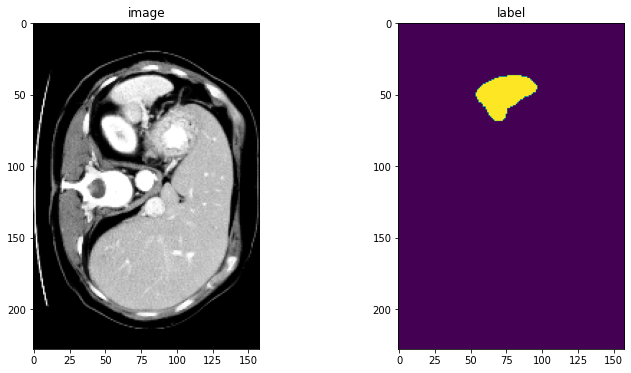

In [6]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

# Caching dataset

In [7]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 32/32 [01:28<00:00,  2.77s/it]
/cluster/home/taheeraa/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 9/9 [00:18<00:00,  2.03s/it]


# Create Model, Loss, Optimizer

In [8]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [13]:
max_epochs = 20
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/20
1/16, train_loss: 0.5240
2/16, train_loss: 0.5339
3/16, train_loss: 0.5834
4/16, train_loss: 0.5403
5/16, train_loss: 0.5417
6/16, train_loss: 0.5838
7/16, train_loss: 0.5475
8/16, train_loss: 0.6001
9/16, train_loss: 0.5877
10/16, train_loss: 0.5926
11/16, train_loss: 0.6081
12/16, train_loss: 0.5674
13/16, train_loss: 0.5621
14/16, train_loss: 0.5957
15/16, train_loss: 0.5971
16/16, train_loss: 0.5693
epoch 1 average loss: 0.5709
----------
epoch 2/20
1/16, train_loss: 0.6001
2/16, train_loss: 0.5487
3/16, train_loss: 0.5476
4/16, train_loss: 0.5696
5/16, train_loss: 0.5702
6/16, train_loss: 0.5906
7/16, train_loss: 0.5877
8/16, train_loss: 0.5319
9/16, train_loss: 0.5251
10/16, train_loss: 0.5830
11/16, train_loss: 0.5952
12/16, train_loss: 0.5783
13/16, train_loss: 0.5655
14/16, train_loss: 0.5133
15/16, train_loss: 0.5989
16/16, train_loss: 0.5124
epoch 2 average loss: 0.5636
saved new best metric model
current epoch: 2 current mean dice: 0.1266
best mean dic

8/16, train_loss: 0.3705
9/16, train_loss: 0.4663
10/16, train_loss: 0.4616
11/16, train_loss: 0.5251
12/16, train_loss: 0.5062
13/16, train_loss: 0.4338
14/16, train_loss: 0.4993
15/16, train_loss: 0.5154
16/16, train_loss: 0.4541
epoch 17 average loss: 0.4642
----------
epoch 18/20
1/16, train_loss: 0.4439
2/16, train_loss: 0.4188
3/16, train_loss: 0.4799
4/16, train_loss: 0.4342
5/16, train_loss: 0.5413
6/16, train_loss: 0.4260
7/16, train_loss: 0.4526
8/16, train_loss: 0.3934
9/16, train_loss: 0.4928
10/16, train_loss: 0.4768
11/16, train_loss: 0.4604
12/16, train_loss: 0.4313
13/16, train_loss: 0.5328
14/16, train_loss: 0.4184
15/16, train_loss: 0.3709
16/16, train_loss: 0.4373
epoch 18 average loss: 0.4507
current epoch: 18 current mean dice: 0.0619
best mean dice: 0.1266 at epoch: 2
----------
epoch 19/20
1/16, train_loss: 0.5014
2/16, train_loss: 0.4944
3/16, train_loss: 0.4046
4/16, train_loss: 0.3829
5/16, train_loss: 0.4658
6/16, train_loss: 0.3702
7/16, train_loss: 0.4918
8

In [14]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.1266 at epoch: 2


# Plot loss and metrics

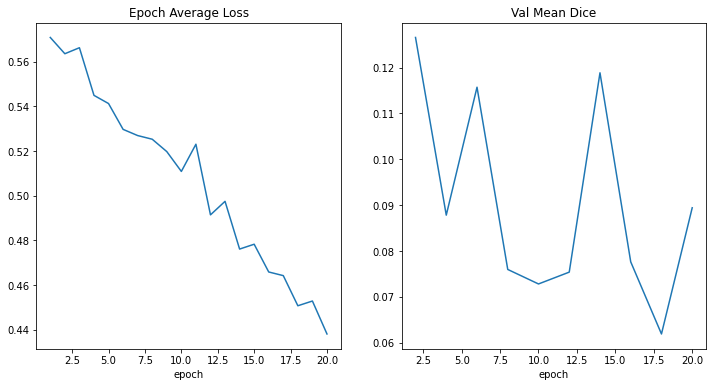

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Check best model output with the input image and label

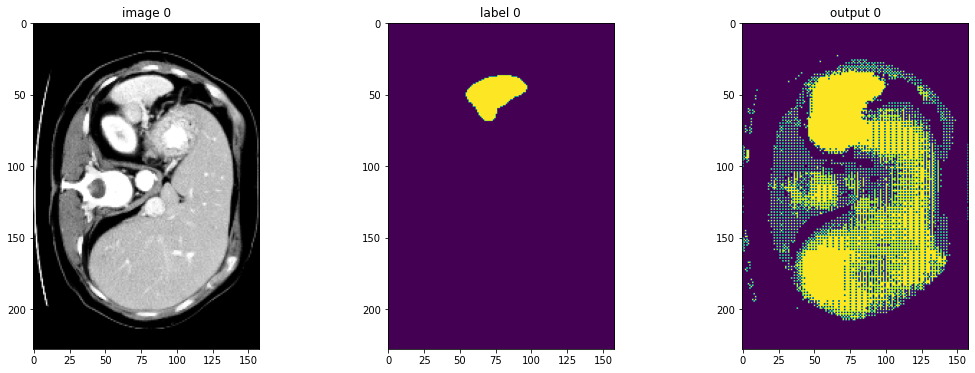

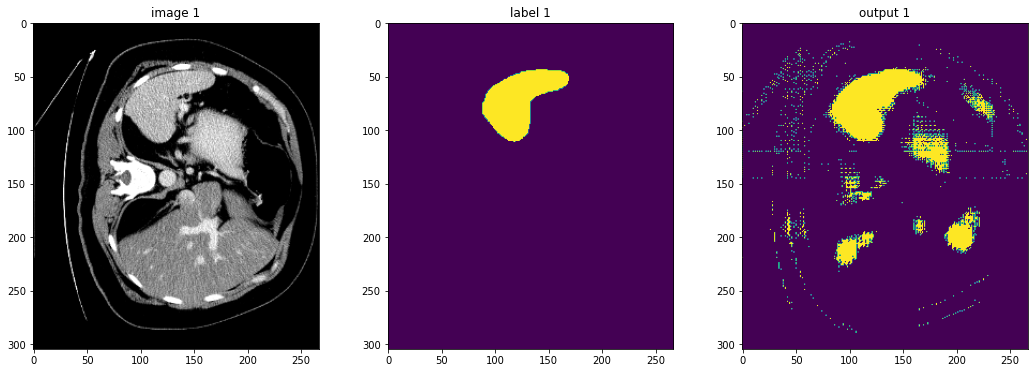

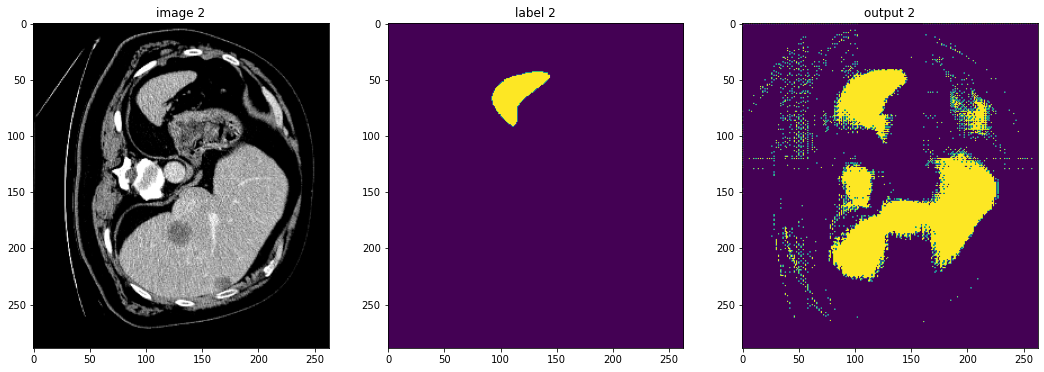

In [16]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

# Evaluation on original image spacings

In [17]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [18]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.1524653285741806


# Inference on test set

In [19]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [23]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

2023-11-14 10:48:28,008 INFO image_writer.py:197 - writing: out/spleen_1/spleen_1_seg.nii.gz


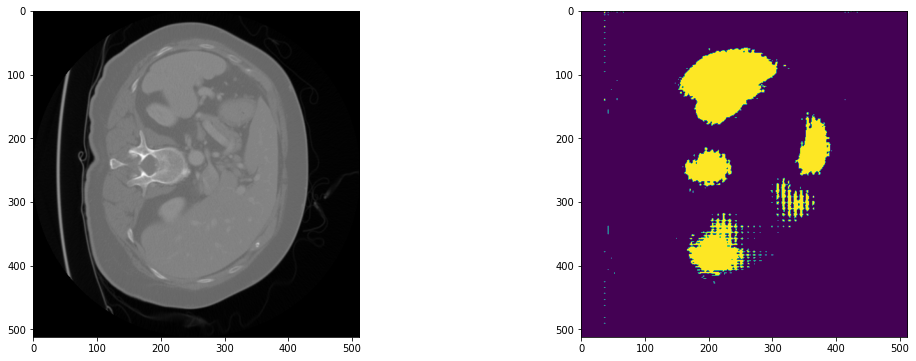

2023-11-14 10:48:36,040 INFO image_writer.py:197 - writing: out/spleen_11/spleen_11_seg.nii.gz


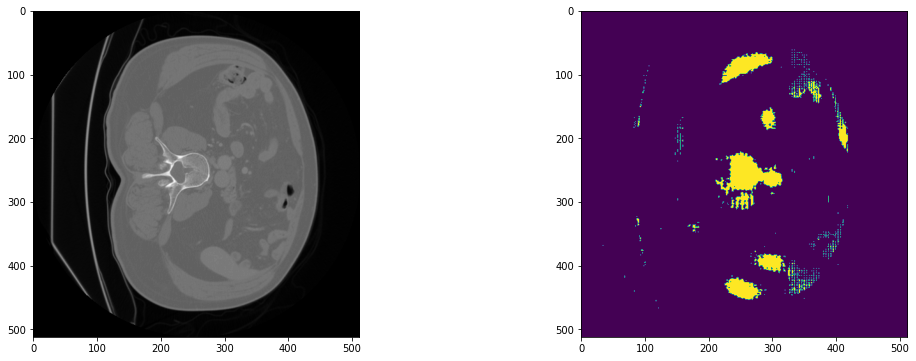

2023-11-14 10:48:50,502 INFO image_writer.py:197 - writing: out/spleen_15/spleen_15_seg.nii.gz


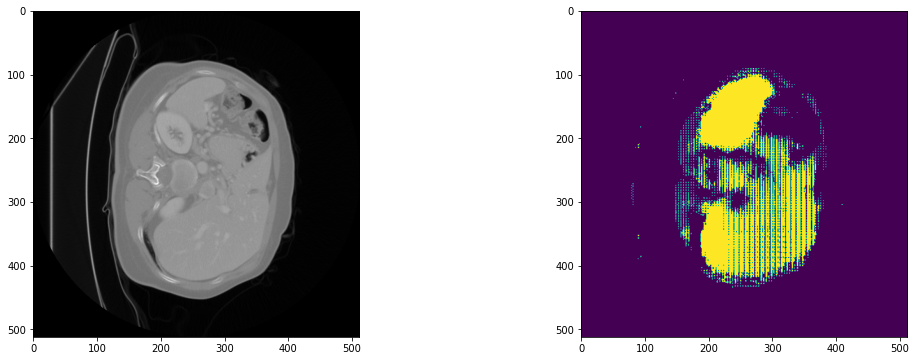

2023-11-14 10:48:53,256 INFO image_writer.py:197 - writing: out/spleen_23/spleen_23_seg.nii.gz


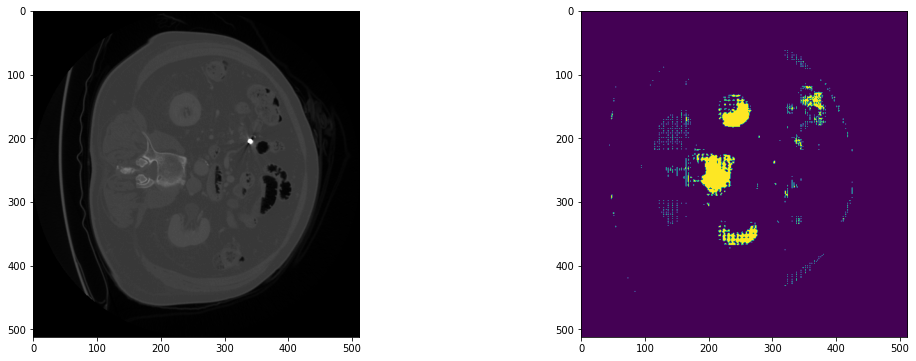

2023-11-14 10:49:00,210 INFO image_writer.py:197 - writing: out/spleen_30/spleen_30_seg.nii.gz


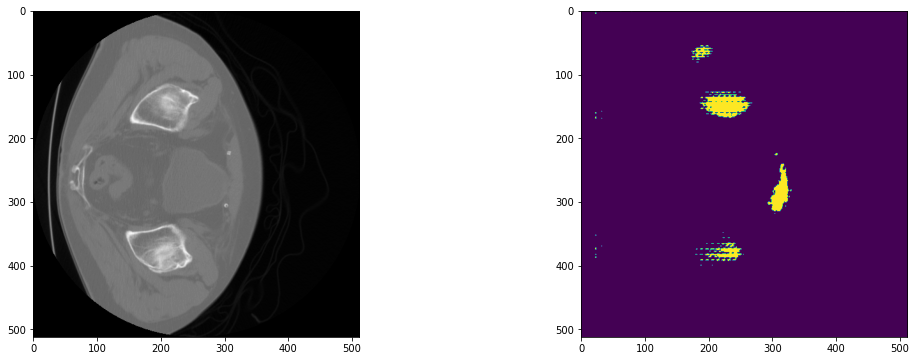

2023-11-14 10:49:06,293 INFO image_writer.py:197 - writing: out/spleen_34/spleen_34_seg.nii.gz


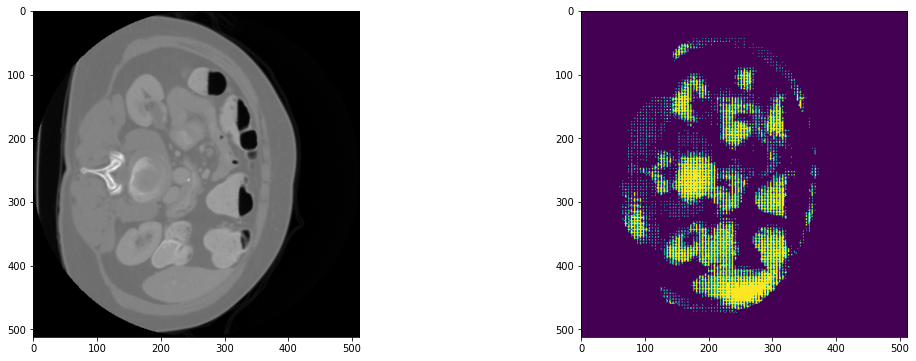

2023-11-14 10:49:09,311 INFO image_writer.py:197 - writing: out/spleen_35/spleen_35_seg.nii.gz


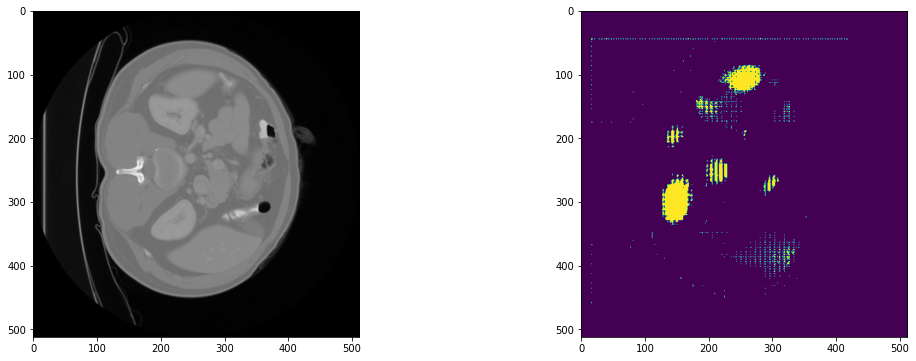

2023-11-14 10:49:12,853 INFO image_writer.py:197 - writing: out/spleen_36/spleen_36_seg.nii.gz


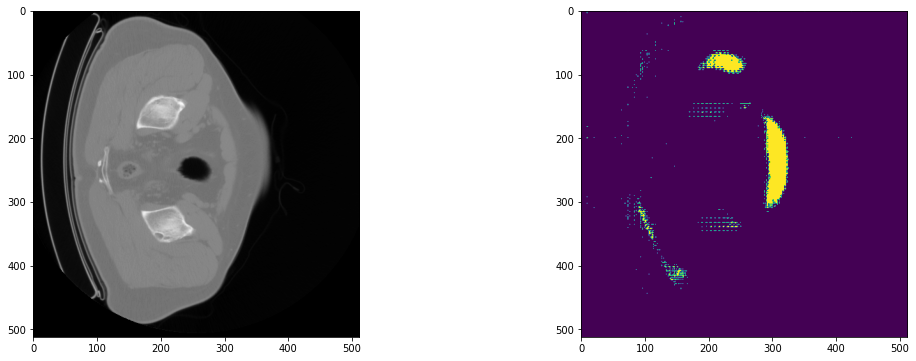

2023-11-14 10:49:19,330 INFO image_writer.py:197 - writing: out/spleen_37/spleen_37_seg.nii.gz


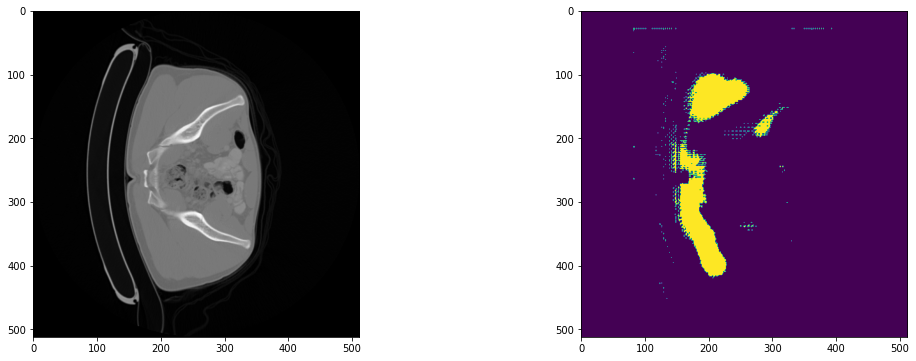

2023-11-14 10:49:24,692 INFO image_writer.py:197 - writing: out/spleen_39/spleen_39_seg.nii.gz


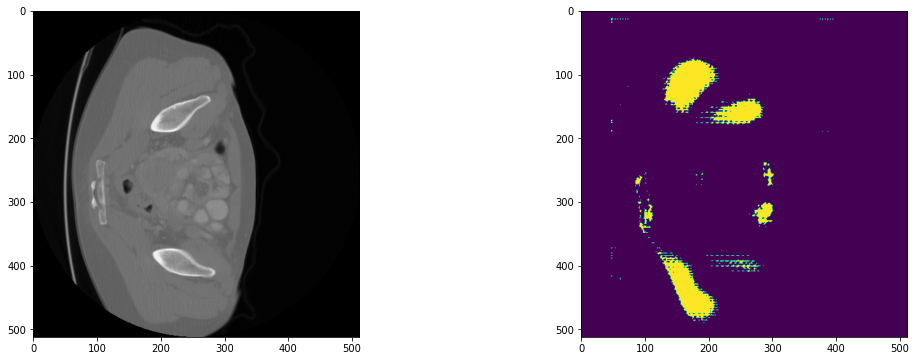

2023-11-14 10:49:28,946 INFO image_writer.py:197 - writing: out/spleen_42/spleen_42_seg.nii.gz


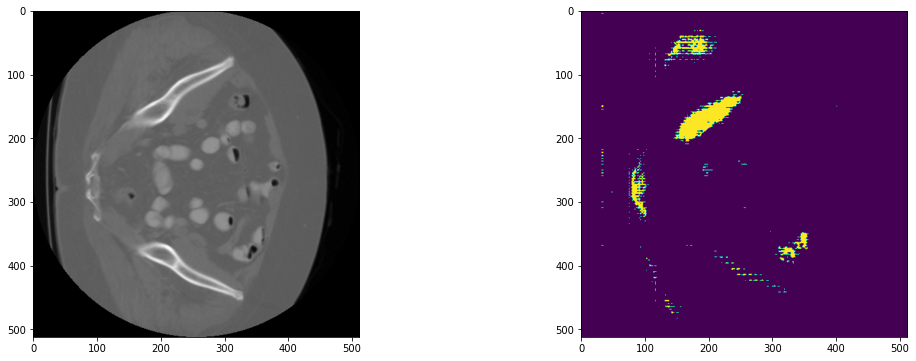

2023-11-14 10:49:32,573 INFO image_writer.py:197 - writing: out/spleen_43/spleen_43_seg.nii.gz


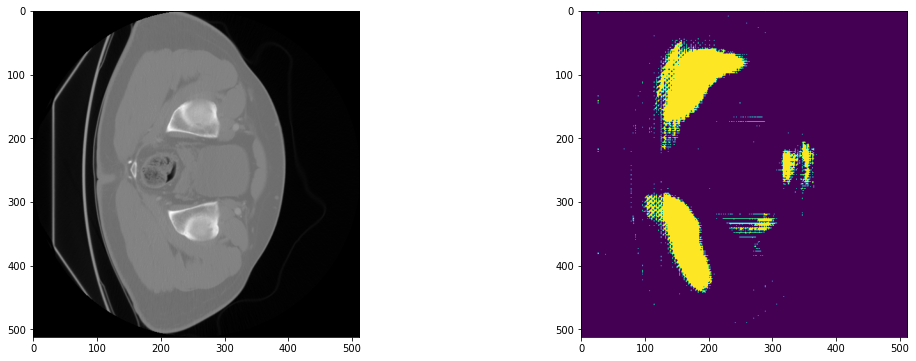

2023-11-14 10:49:38,125 INFO image_writer.py:197 - writing: out/spleen_48/spleen_48_seg.nii.gz


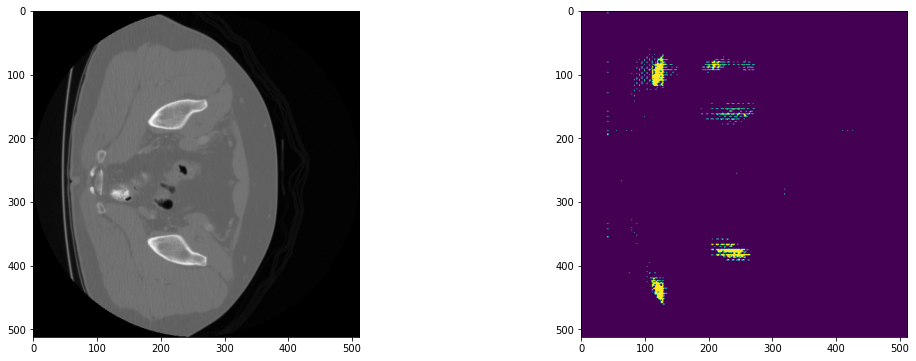

2023-11-14 10:49:41,076 INFO image_writer.py:197 - writing: out/spleen_50/spleen_50_seg.nii.gz


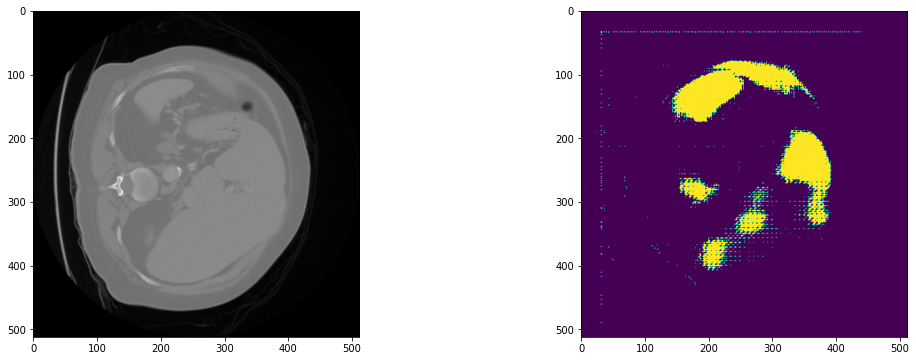

2023-11-14 10:49:42,832 INFO image_writer.py:197 - writing: out/spleen_51/spleen_51_seg.nii.gz


Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/multiprocessing/queues.py", line 241, in _feed
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/multiprocessing/queues.py", line 24

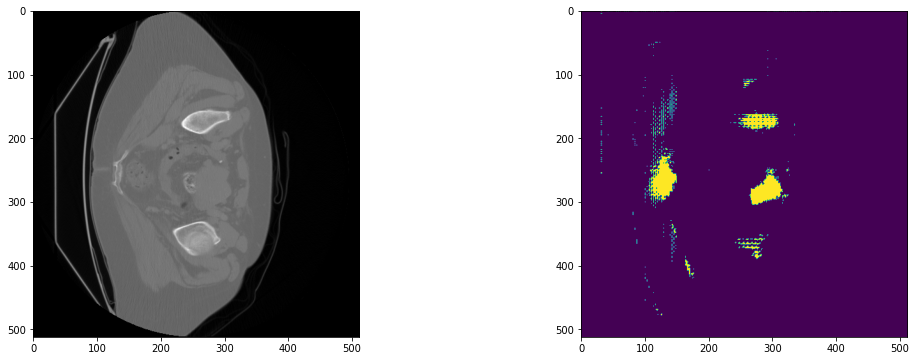

2023-11-14 10:49:46,303 INFO image_writer.py:197 - writing: out/spleen_54/spleen_54_seg.nii.gz


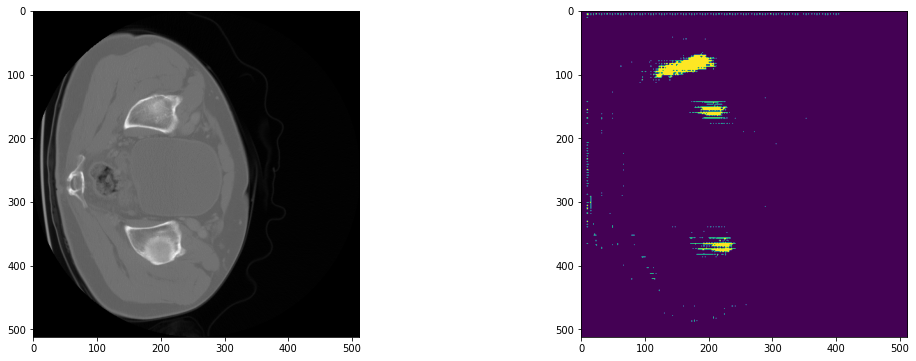

2023-11-14 10:49:50,221 INFO image_writer.py:197 - writing: out/spleen_55/spleen_55_seg.nii.gz


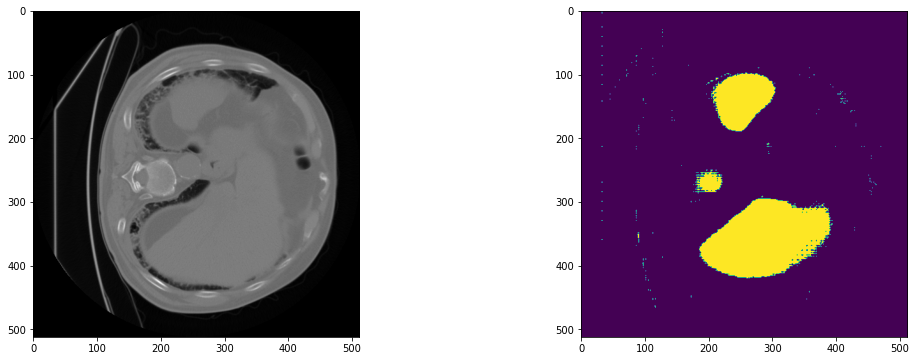

2023-11-14 10:49:52,174 INFO image_writer.py:197 - writing: out/spleen_57/spleen_57_seg.nii.gz


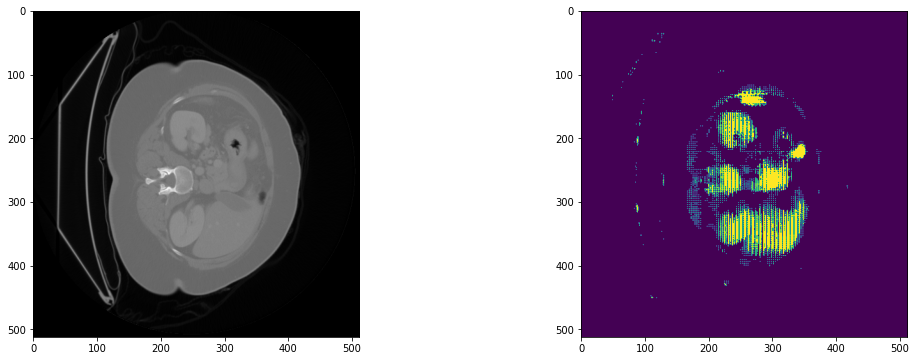

2023-11-14 10:49:54,285 INFO image_writer.py:197 - writing: out/spleen_58/spleen_58_seg.nii.gz


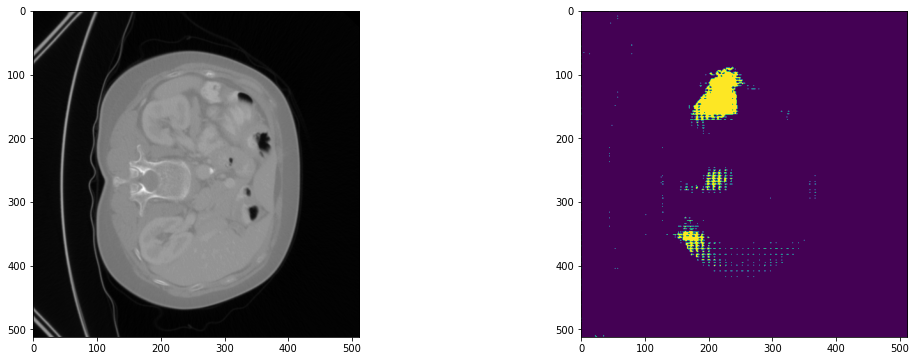

2023-11-14 10:49:55,796 INFO image_writer.py:197 - writing: out/spleen_7/spleen_7_seg.nii.gz


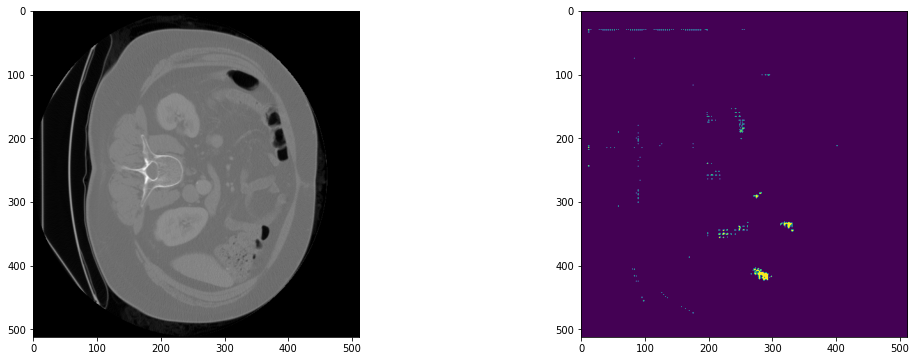

In [24]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

        # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_output[0].meta["filename_or_obj"])

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
        plt.show()